2.2　複数資産の最適資産構成比率

　本例では、資産構成比率を無数に発生させることで、その臨界線を導出して効率的フロンティアを描くアプローチを採用します。以下の事例では、5資産の最適資産構成比率のソースコードを示しますが、[4]セル目の資産数(n＝5）を変更すれば、このソースコードを用いて10資産でも100資産でも、実装可能です。



In [1]:
#[1]ライブラリ読み込み
import pandas_datareader as data
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

　香港H株市場の時価総額上位銘柄、テンセント（700.HK）、浙江吉利汽車控股（175.HK）中国移動（チャイナ・モバイル、941.HK）、アリババ（9988.HK）、中国建設銀行（939.HK）の5資産の最適資産構成を算出します。これらのH株市場に上場される中国本土企業は、香港ドル建てで株式が発行され、市場で取引されます。

In [2]:
#[2]株価日次データの取得
tickers=['9988.HK','700.HK','941.HK','175.HK','939.HK']
start=datetime.date(2020,1,1)#標本期間を2020年1月1日から
end=datetime.date(2021,12,31)#2021年12月31日までに指定
data=data.DataReader(tickers,'stooq',start=start,end=end).sort_values(by='Date',ascending=True)

In [ ]:
#[3]データ前処理
df=data.Close.pct_change().dropna()
df.head()

　2_1の2資産モデルの実装例と異なるのは、この[4]からです。まずここでは、資産数（n＝5）と組み合わせ比率の数(p＝10,000)を定義します。次に年率の平均リターン（Ep）と分散・共分散（Cov_Rp）を算出します。mean_variance=[]は、後で各組合せごとに算出する平均値・分散（共分散）を収納するための空配列です。weight_ratio=[]は、この各平均値・分散（共分散）に対応する各資産構成比率を格納するための空配列です。ticker_list=[]は同様に、各平均値・分散（共分散）に対応する各銘柄を保存するための空配列です。

In [4]:
#[4]資産の数・反復回数の設定と平均リターン・リスクの算出
n=5 #資産数
p=10000 #組み合わせ比率の種類
E_Rp=df.mean()*250 #全銘柄の平均リターン
Cov_Rp = df.cov()*250 #全銘柄の分散共分散
mean_variance=[] #リターンと分散値を格納するための空配列の準備
weight_ratio=[] #資産構成比率を格納するための空配列の準備
ticker_list=[] #銘柄リストを格納するための空配列の準備
np.random.seed(101) #資産構成比率算出に際し乱数を発生させるための初期値

　次のセルでは、p種類の資産組み合わせ比率をランダムに（本例ではp=10,000）作成して、p種類のポートフォリオの期待リターンとリスクの組合せを導出します。まず、n種類の銘柄のp種類のランダムな組み合わせのnumpy配列であるportfolio、その組み合わせ配列のweightsを1-2行目で定義します。続いて、生成されるランダムな組合せ比率を用いて、ポートフォリオ全体の期待リターンと分散共分散の計算をp回反復計算します。
  算出された結果およびランダムに生成した諸比率、銘柄名は、「配列名.append()」により、ぞれぞれmean_variance、weight_ratio、ticker_listに保存します。この時点で、mean_varianceの２つの配列である期待リターンと分散をプロットすれば、n種類の資産の効率的フロンティアは描けます。


In [5]:
#[5]資産の数・反復回数の設定と効率的フロンティアの導出
for i in range(p): #以下をp回反復
  portfolio=np.random.choice(list(df.columns),n,replace=False) #ランダムな銘柄選択
  weights=np.random.rand(n)#構成比率のランダムな組合せ
  weights=weights/sum(weights)#構成比率上限が1であることを定義
  total_variance=0
  total_return=0
  for i in range(len(portfolio)):#以下をポートフォリオの組合せごとに反復
    total_return+=weights[i]* E_Rp.loc[portfolio[i]] #期待リターンの計算
    for j in range(len(portfolio)):#以下をポートフォリオの組合せごとに反復
      total_variance+=weights[i]*weights[j]*Cov_Rp.loc[portfolio[i],portfolio[j]] #分散共分散の計算
  mean_variance.append([total_return,total_variance])#リターン・リスク結果の保存
  weight_ratio.append(weights)#資産構成比率組合せ結果の保存
  ticker_list.append(portfolio)#銘柄組合せ結果の保存

　効率的フロンティアから、シャープレシオを算出し、その最大値が達成される期待リターン、リスク、資産構成比率を算出する手順は、2_1の2資産モデルの場合と同様です。

In [6]:
#[6]最適資産構成時の期待リターン・リスクの算出
rf=0.03157 #無リスク資産の利回り(香港ドル10年債≒米ドル10年債)
columns =["return", "risk"]
mean_variance = pd.DataFrame(mean_variance,columns=columns)#pandasデータフレームへ変換
mean_variance['Sharp_Ratio'] = pd.DataFrame((mean_variance['return']-rf)/mean_variance['risk'])
mean_variance['index'] = mean_variance.reset_index().index
optimal=pd.DataFrame(mean_variance.loc[mean_variance['Sharp_Ratio'].idxmax()])
opt_index=optimal.iloc[3,0] #シャープレシオ最大値の行番号
opt_risk=optimal.iloc[1,0]#シャープレシオ最大時のリスク
opt_return=optimal.iloc[0,0]#シャープレシオ最大時の期待リターン
max_sr=optimal.iloc[2,0] #シャープレシオ最大値

　[6]では、シャープレシオ最大時の期待リターンとリスクが算出されました。これらはopt_return、opt_riskと入力すれば結果は出力できます。これらの期待リターン、リスクを実現する際の銘柄と組み合わせ比率のデータを[7]において整理します。

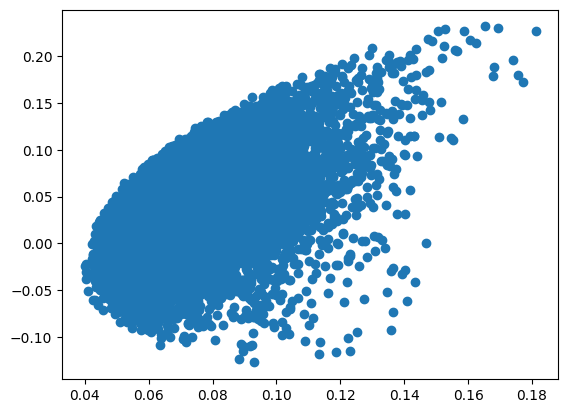

In [7]:
#[7]最適資産構成算出結果の後処理
weight_ratio = pd.DataFrame(weight_ratio)#資産構成比率をpandasデータフレームへ変換
opt_weights=weight_ratio.loc[opt_index]#最適資産構成比を抽出
ticker_list = pd.DataFrame(ticker_list)#銘柄組合せをpandasデータフレームへ変換
ticker_list2=ticker_list.loc[opt_index]#最適資産構成時の銘柄組合せを抽出
asset_allocation = pd.DataFrame(index=[])#銘柄と最適資産構成比率を統合
asset_allocation['tickers']=pd.DataFrame(ticker_list2)
asset_allocation['ratio']=pd.DataFrame(opt_weights)
plt.scatter(x=mean_variance['risk'],y=mean_variance['return'])#可視化

　最後に効率的フロンティア、資本市場線、そしてその接点時の期待リターン、リスク、資産構成比率を表示します。

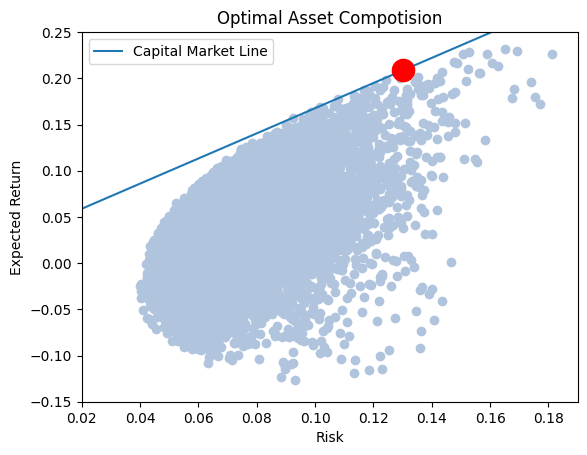

期待リターン 0.2085
リスク 0.1300
シャープレシオ 1.3609


,tickers,ratio
0,175.HK,0.4652
1,939.HK,0.0861
2,700.HK,0.3976
3,9988.HK,0.0062
4,941.HK,0.0449


In [8]:
#[8]効率的フロンティアとCMLの導出
def CML(rf,sharp_R,label):#無リスク資産・シャープレシオsharp_Rの関数定義
    Risk = [x/100 for x in range(100)] #横軸Riskを設定
    ExpectedReturn = [rf+max_sr*x for x in Risk] #縦軸Epを算出
    plt.plot(Risk,ExpectedReturn,label=label)
    plt.xlabel("Risk")
    plt.xlim(0.02,0.19) #横軸の幅設定
    plt.ylabel("Expected Return")
    plt.ylim(-0.15,0.25) #縦軸の幅設定
    plt.title("Optimal Asset Compotision")
    plt.plot(opt_risk,sharp_R,"ro",linestyle = "--",markersize=16) #資本市場線の作成

CML(rf,opt_return,"Capital Market Line") #CML導出
plt.scatter(x=mean_variance['risk'],y=mean_variance['return'],c="lightsteelblue")#効率的フロンティアの作成
plt.legend()
plt.show()
print('期待リターン {:.4f}'.format(opt_return))
print('リスク {:.4f}'.format(opt_risk))
print('シャープレシオ {:.4f}'.format(max_sr))
pd.options.display.precision = 4
asset_allocation